# Uncertainty and sensitivity

TEA/LCA is a powerful tool to understand the potential sustainability of a technology. But it can be extremely difficult to navigate uncertainties in design decisions (e.g., refinery size and location), market variability, and technological performance. Evaluating just one representative scenario (under a single set of assumptions) gives an incomplete picture that is not conclusive. This is especially true for conceptual and early-stage technologies, which have higher levels of uncertainty. We need to pair TEA/LCA with rigorous uncertainty/sensitivity analyses to explore the landscape of potential outcomes, identify representative scenarios (through sensitivity analysis), and establish technological performance targets. To learn more about expediting RD&D through modeling, we recommend reading on [quantitive sustainable design (QSD) methodology](https://pubs.rsc.org/en/content/articlelanding/2022/ew/d2ew00431c).

![uncertainty](uncertainty_sensitivity_overview.png)

As one of its central features, BioSTEAM streamlines TEA/LCA with rigorous uncertainty/sensitivity analyses to empower researchers with the ability to navigate uncertainty and guide RD&D. Using NREL's model for cellulosic ethanol production from cornstover as a conceptual case study, this tutorial will demonstrate how to construct a model and perform Monte Carlo-based uncertainty/sensitivity analyses to establish potential targets for improvement. 

### Probability distributions

**Let's first learn how to create common parameter distributions used in Monte Carlo uncertainty analysis.**

![distributions](../images/distributions.png)

* Use a **triangular distribution**  if the input parameter is uncertain within given limits, but is heuristically known to take a particular value.

* Use a **uniform distribution** if the theoretical limits of the parameter is known, but no information is available to discern which values are more probable.

## Framework

BioSTEAM streamlines uncertainty analysis with an object-oriented framework where a [Model](../API/evaluation/Model.txt) object samples from parameter distributions and evaluates sustainability indicators at each new condition. In essence, a Model object sets parameter values, simulates the biorefinery system, and evaluates indicators across an array of samples.

![model](model_UML_light.png)

On the backend, Model objects cut down simulation time using a number of strategies, including sorting the samples to minimize perturbations to the system between simulation. 


## Creating a Model object

**Model objects are used to evaluate indicators given a set of system parameters.**

Create a Model object of the cellulosic ethanol:

In [1]:
import biosteam as bst
from biorefineries import cellulosic
bst.nbtutorial()
br = cellulosic.Biorefinery()
br

Biorefinery(
    # dry at 20% moisture content
    feedstock='cornstover',
    # final product
    product='ethanol',
    # whether to model boiler/cooling tower blowdown to wastewater
    include_blowdown_recycle=False,
)


The Model object begins with no parameters and no indicators: 

In [2]:
model = br.model
tea = br.tea
feedstock = br.feedstock
model

Model:
parameters: None
indicators: None


### Add sustainability/performance indicators

**Example:** Add the minimum ethanol selling price (MESP) as an indicator.

In [3]:
@model.indicator(units='USD/kg')
def MESP(): return tea.solve_price(br.ethanol)

model

Model:
parameters: None
indicators: MESP [USD/kg]


**Problem:** Add the total capital investment (TCI) as an indicator.

In [4]:
# Hint: tea.TCI / 1e6 is the total capital investment in 10^6 * USD
@model.indicator(units='10^6 USD')
def TCI(): return tea.TCI / 1e6 # total capital investment

In [5]:
model

Model:
parameters: None
indicators: MESP [USD/kg]
            TCI [10^6 USD]


Note that the decorator uses the function to create an Indicator object and adds it to the model.

### Add input parameters

**Example:** Add fermentation performance parameters and a processing capacity parameter.

In [6]:
fermentation = br.R303
ethanol_rxn = fermentation.cofermentation[0]
xylose_rxn = fermentation.cofermentation[4]
@model.parameter(
    element='fermentation',
    units='% theoretical', # Metadata (does not affect simulation)
    bounds=(85, 95), # Lower and upper bound
    distribution='uniform', # Same as shape.Uniform(lower, upper)
    baseline=0.5 * (80 + 95), # Baseline assumption
)
def set_glucose_to_ethanol_yield(glucose_to_ethanol_yield):
    ethanol_rxn.X = glucose_to_ethanol_yield / 100
    
@model.parameter(
    element='fermentation', units='% theoretical',
    bounds=(70, 90), # Baseline defaults to the average of the lower and upper bounds.
    distribution='uniform',
)
def set_xylose_to_ethanol_yield(xylose_to_ethanol_yield):
    xylose_rxn.X = xylose_to_ethanol_yield / 100

processing_capacity = feedstock.F_mass * tea.operating_hours / 1e3 # Annual processing capacity MT / y
lb = processing_capacity * 0.9
ub = processing_capacity * 1.1
@model.parameter(
    units='MT/yr',
    bounds=(lb, ub),
    element='Biorefinery',
    baseline=processing_capacity,
    distribution='triangular', # Defaults to shape.Triangular(lower=lb, midpoint=baseline, upper=ub)
)
def set_processing_capacity(processing_capacity):
    feedstock.F_mass = 1e3 * processing_capacity / tea.operating_hours
    
model

Model:
parameters: Fermentation - Glucose to ethanol yield [% theoretical]
            Fermentation - Xylose to ethanol yield [% theoretical]
            Biorefinery - Processing capacity [MT/yr]
indicators: MESP [USD/kg]
            TCI [10^6 USD]


**Example:** Add feed price as a parameter.

In [7]:
lb = feedstock.price * 0.9 # Minimum price
ub = feedstock.price * 1.1 # Maximum price

# Hint: you can set feedstock price in USD/kg by feedstock.price = price
@model.parameter(
    element='Feedstock', units='USD/kg',
    bounds=(lb, ub), # Baseline defaults to the average of the lower and upper bounds.
    distribution='uniform',
)
def set_feed_price(price):
    feedstock.price = price
    

In [8]:
model

Model:
parameters: Fermentation - Glucose to ethanol yield [% theoretical]
            Fermentation - Xylose to ethanol yield [% theoretical]
            Biorefinery - Processing capacity [MT/yr]
            Feedstock - Price [USD/kg]
indicators: MESP [USD/kg]
            TCI [10^6 USD]


Note that the `model.parameter` decorator uses the function to create a Parameter object and adds it to the model.

### Overview of the model

Get dictionary that contain DataFrame objects of parameter distributions:

In [9]:
df_dct = model.get_distribution_summary()
df_dct['Uniform']

,Element,Name,Units,Shape,lower,upper
0,fermentation,Glucose to ethanol yield,% theoretical,Uniform,85,95
1,fermentation,Xylose to ethanol yield,% theoretical,Uniform,70,90
2,Feedstock,Price,USD/kg,Uniform,0.0464,0.0567


In [10]:
df_dct['Triangle']

,Element,Name,Units,Shape,lower,midpoint,upper
0,Biorefinery,Processing capacity,MT/yr,Triangle,7.89e+05,8.77e+05,9.64e+05


Evaluate baseline scenario:

In [11]:
baseline_scenario = model.get_baseline_scenario()
baseline_scenario

fermentation Glucose to ethanol yield [% theo...     87.5
             Xylose to ethanol yield [% theor...       80
Biorefinery  Processing capacity [MT/yr]         8.77e+05
Feedstock    Price [USD/kg]                        0.0516

In [12]:
model(baseline_scenario)

- MESP [USD/kg]  0.72
  TCI [10^6 USD]  383

### Monte Carlo uncertainty analysis

Sample from a joint distribution, and simulate samples:

In [13]:
import numpy as np
N_samples = 200
rule = 'L' # For Latin-Hypercube sampling
np.random.seed(1234) # For consistent results
samples = model.sample(N_samples, rule)
model.load_samples(samples, sort=True)
model.evaluate(
    notify=100 # Also print elapsed time after 50 simulations
) 

[100] Elapsed time: 12 sec
[200] Elapsed time: 24 sec


All data from simulation is stored in `<Model>.table`:

In [14]:
full_problem_space = model.table.copy() # All evaluations are stored as a pandas DataFrame
full_problem_space

Element                             fermentation                                                         Biorefinery      Feedstock             -  \
Feature Glucose to ethanol yield [% theoretical] Xylose to ethanol yield [% theoretical] Processing capacity [MT/yr] Price [USD/kg] MESP [USD/kg]   
0                                      85.4                                     79.2                        8.88e+05         0.0544         0.741   
1                                      85.1                                     73.7                        8.34e+05         0.0487         0.732   
2                                      86.8                                     71.6                        9.15e+05         0.0471         0.707   
3                                      87.8                                       87                        9.31e+05         0.0539         0.712   
4                                      88.4                                     74.2                        8.57e+05         0.0469         0.707   
..                                      ...                                      ...                             ...            ...           ...   
195                                    92.1                                     86.4                        8.17e+05         0.0479         0.689   
196                                    85.3                                     79.9                        9.05e+05         0.0545         0.739   
197                                    90.4                                     86.1                        8.15e+05         0.0481         0.695   
198                                    93.1                                     80.4                        8.89e+05         0.0498         0.694   
199                                    89.7                                     84.7                        9.04e+05         0.0487          0.69   

Element                 
Feature TCI [10^6 USD]  
0                  387  
1                  374  
2                  395  
3                  395  
4                  379  
..                 ...  
195                363  
196                391  
197                363  
198                383  
199                388  

[200 rows x 6 columns]

Create a kernel density scatter plot to visualize the two economic indicators under uncertainty:

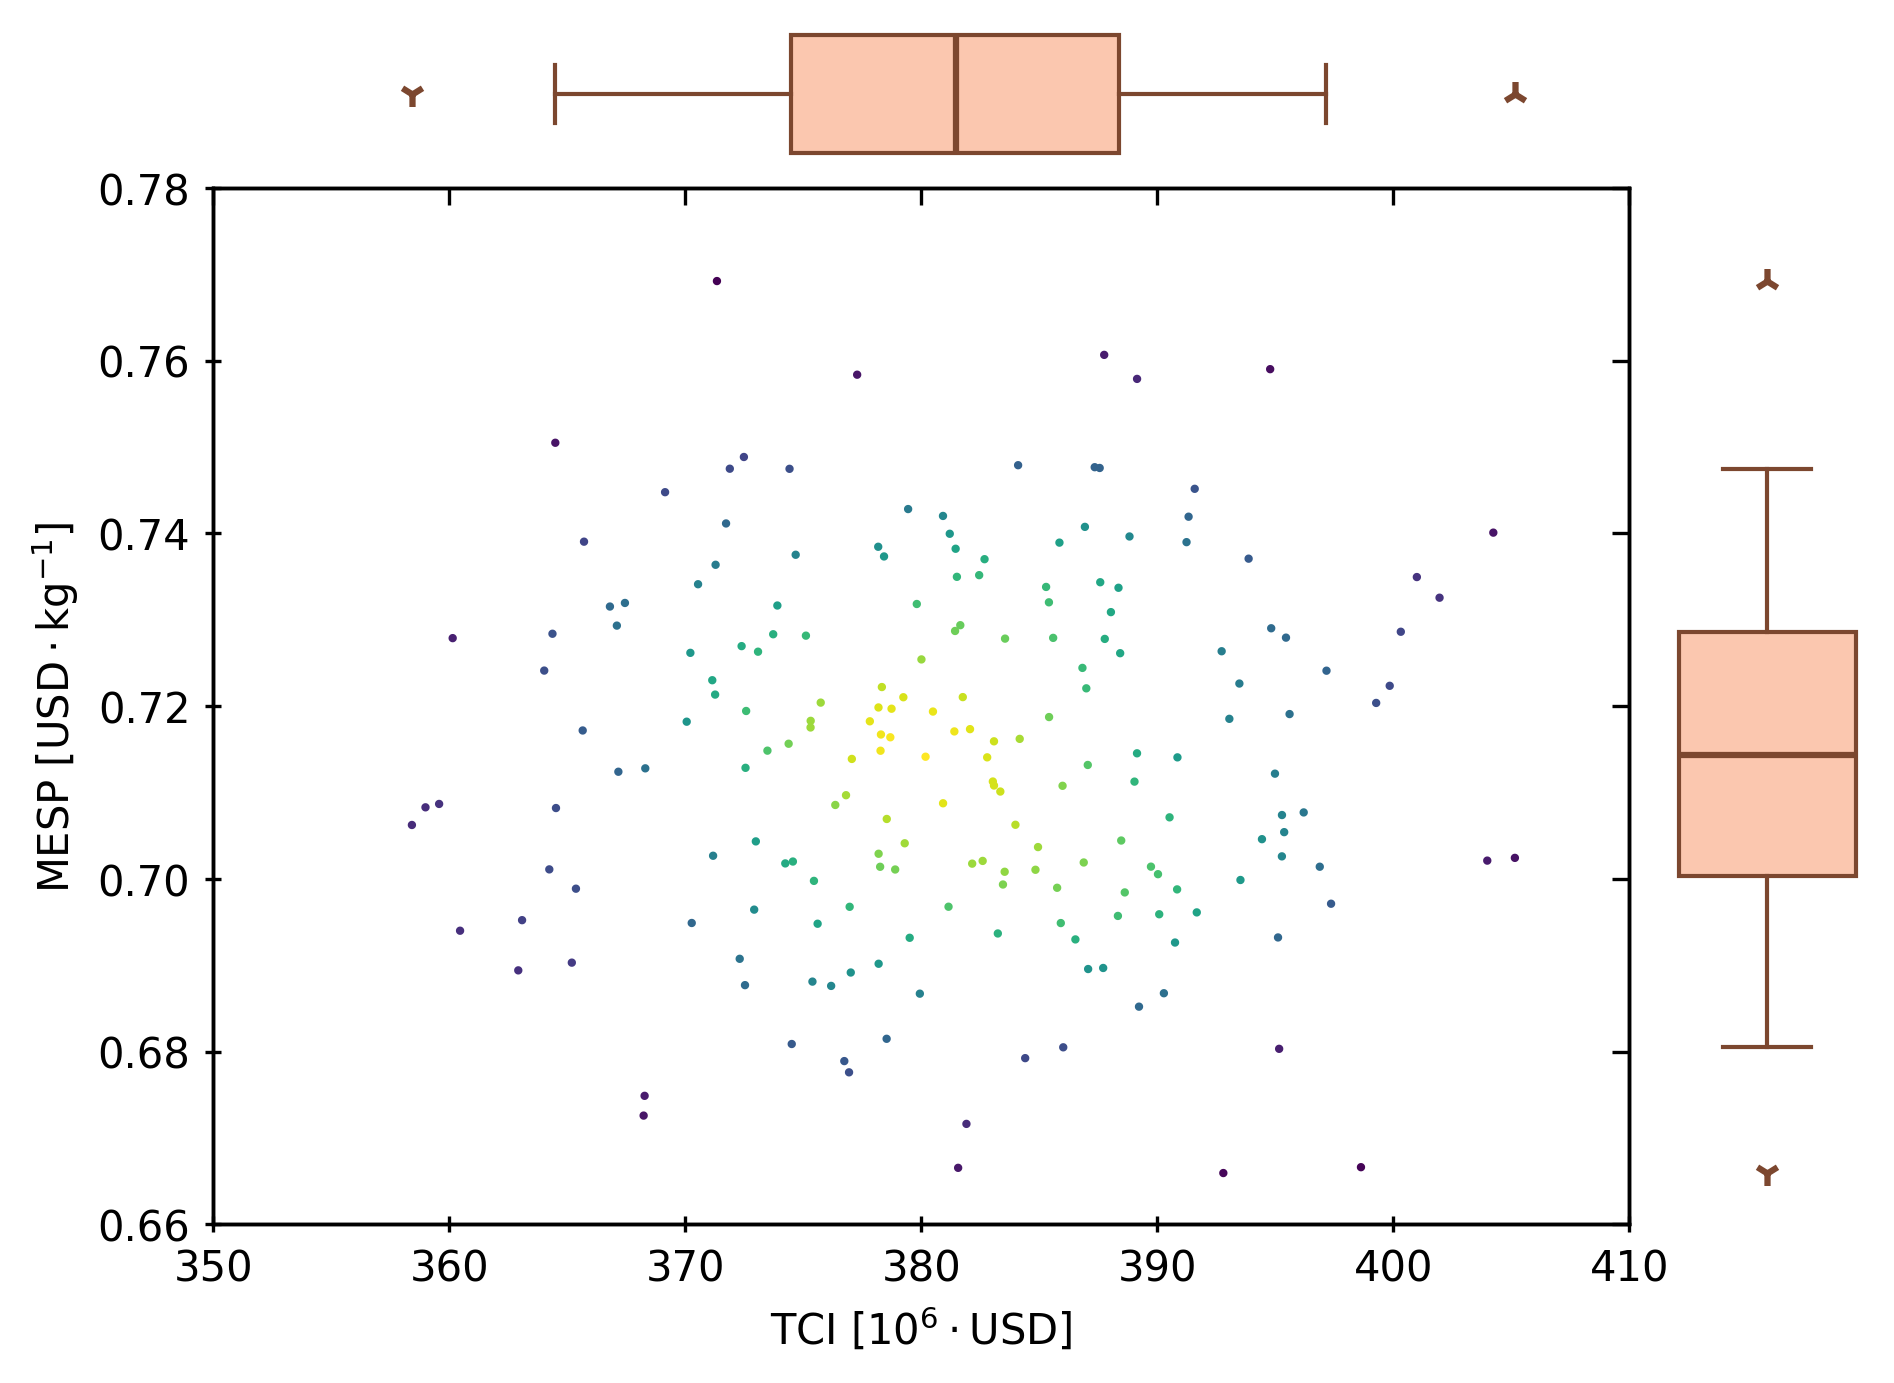

In [15]:
import thermosteam as tmo
import matplotlib.pyplot as plt
format_units = tmo.units_of_measure.format_units
ylabel = f"MESP [{format_units('USD/kg')}]"
xlabel = f"TCI [{format_units('10^6 USD')}]"
def plot_uncertainty(table): # This function will be useful later
    fig, ax, axes = bst.plots.plot_kde(
        y=table[MESP.index], 
        x=table[TCI.index],
        ylabel=ylabel,
        xlabel=xlabel,
        aspect_ratio=1.1,
    )
plot_uncertainty(model.table)

Note that the brighter areas signify that scenario results are more clustered and hence, more probable. 

## Sensitivity with Spearman's rank order correlation

Model objects also presents methods for sensitivity analysis such as Spearman's correlation, a measure of monotonicity between variables:

In [16]:
df_rho, df_p = model.spearman_r()
print(df_rho['-', 'MESP [USD/kg]'])

Element       Parameter                               
fermentation  Glucose to ethanol yield [% theoretical]    -0.47
              Xylose to ethanol yield [% theoretical]    -0.462
Biorefinery   Processing capacity [MT/yr]                 -0.13
Feedstock     Price [USD/kg]                              0.746
Name: (-, MESP [USD/kg]), dtype: float64


Create a tornado plot of Spearman's correlation between all parameters and IRR:

(<Figure size 1920x1440 with 3 Axes>,
 <Axes: xlabel="Spearman's correlation with MESP [USD/kg]">)

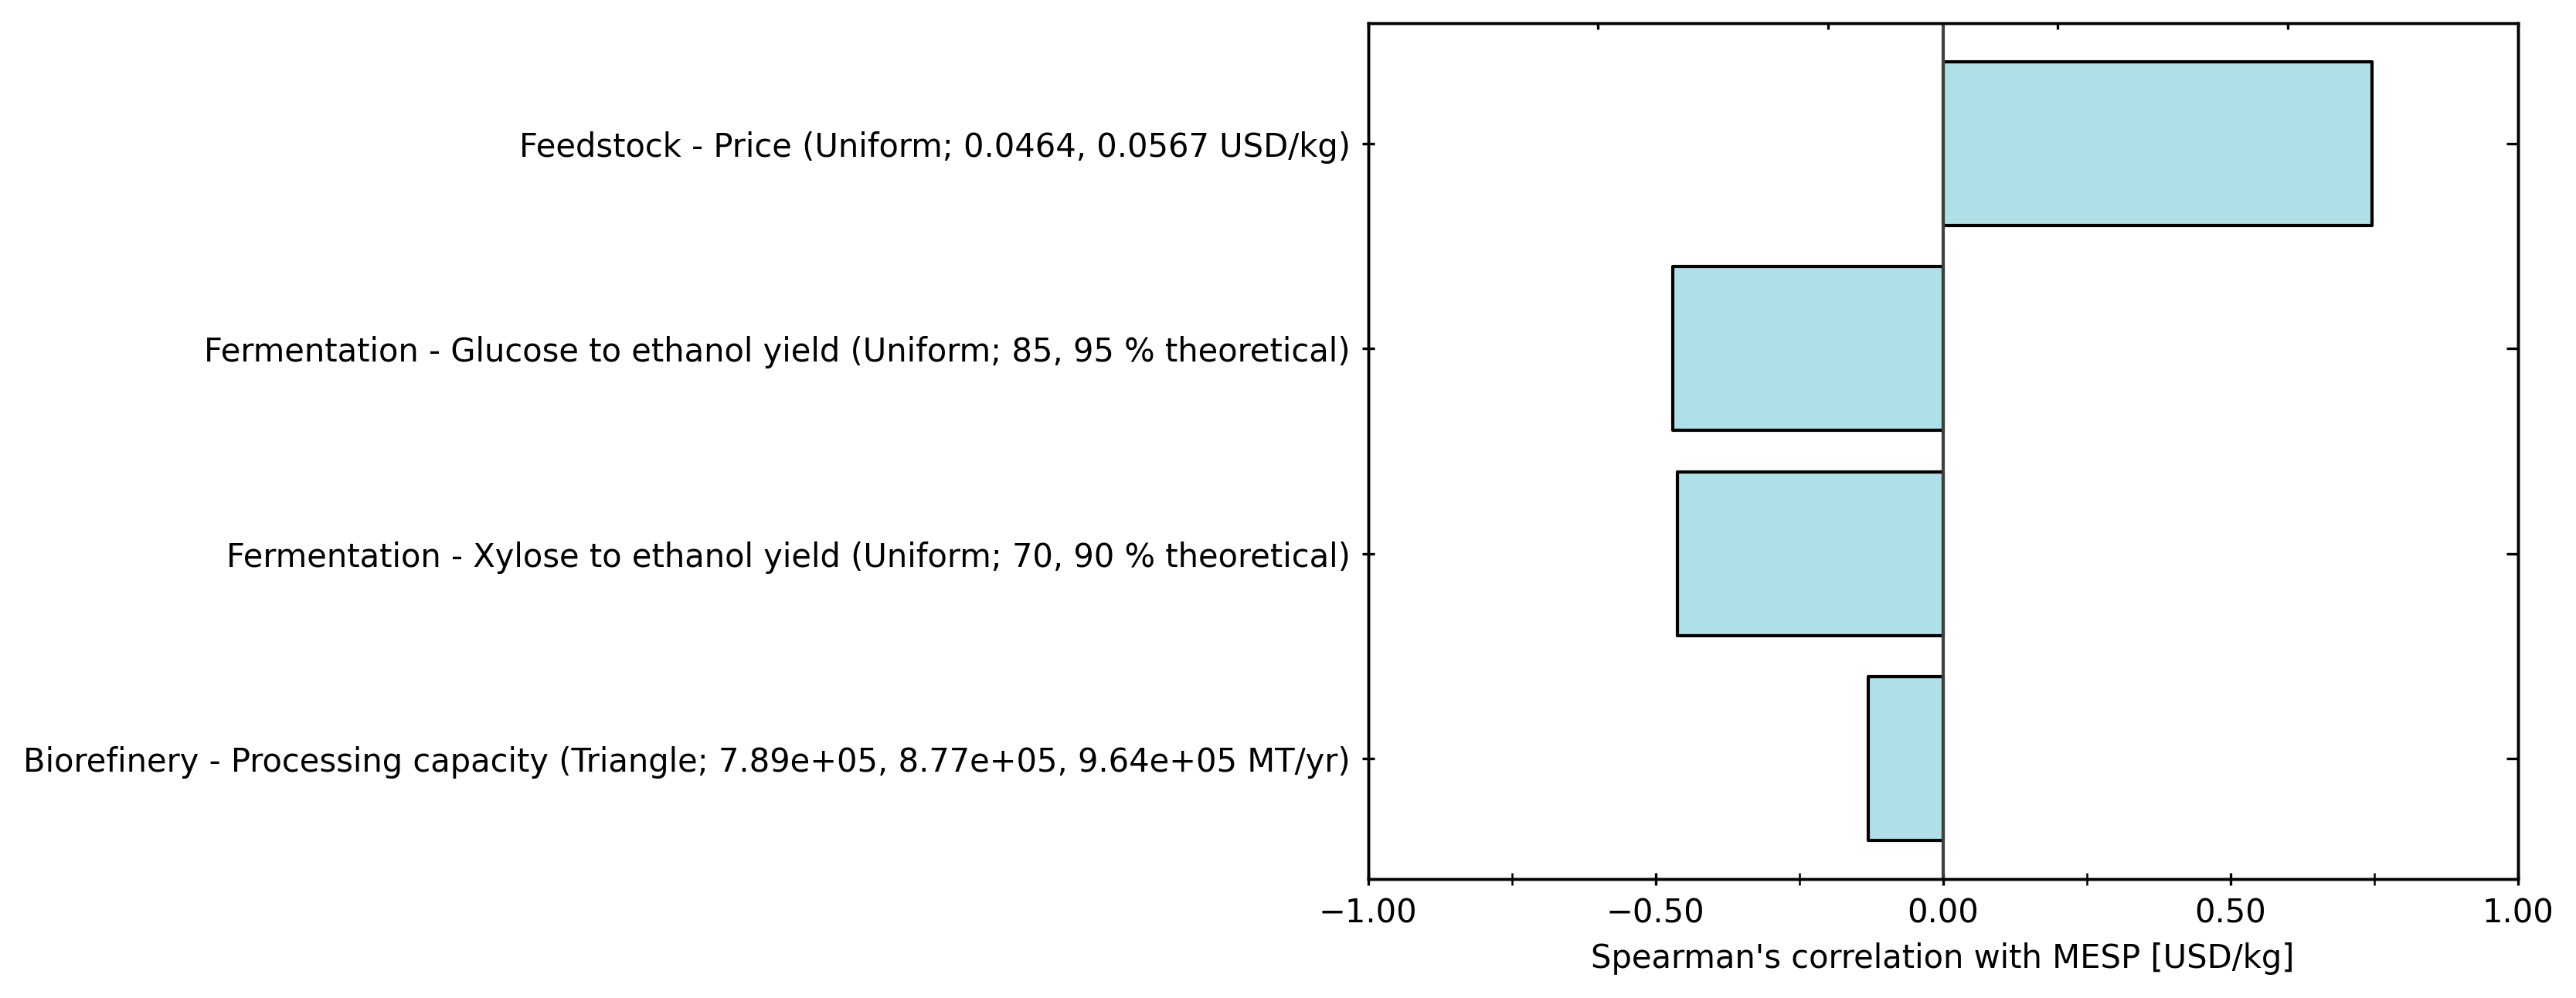

In [17]:
bst.plots.plot_spearman_1d(df_rho['-', 'MESP [USD/kg]'], 
                           index=[i.describe() for i in model.parameters],
                           name='MESP [USD/kg]')

## Single point sensitivity

A quick way to evaluate sentivity is through single point sensitivity analysis, whereby a metric is evaluated at the baseline and at the lower and upper limits of each parameter. This method ignores the interactions between parameters and their distributions, but can help screen whether a system is sensitive to a given parameter. Model objects also facilitate this analysis:

In [18]:
baseline, lower, upper = model.single_point_sensitivity()
print('BASELINE')
print('--------')
print(baseline)
print()
print('LOWER')
print('-----')
print(lower)
print()
print('UPPER')
print('-----')
print(upper)

BASELINE
--------
Element  Feature       
-        MESP [USD/kg]    0.72
         TCI [10^6 USD]    383
dtype: float64

LOWER
-----
Element                                                      -               
Feature                                          MESP [USD/kg] TCI [10^6 USD]
Element      Feature                                                         
fermentation Glucose to ethanol yield [% theo...         0.728            384
             Xylose to ethanol yield [% theor...         0.738            385
Biorefinery  Processing capacity [MT/yr]                 0.736            359
Feedstock    Price [USD/kg]                              0.695            383

UPPER
-----
Element                                                      -               
Feature                                          MESP [USD/kg] TCI [10^6 USD]
Element      Feature                                                         
fermentation Glucose to ethanol yield [% theo...         0.701            3

Create a tornado plot of the lower and upper values of the IRR:

(<Figure size 1920x1440 with 3 Axes>, <Axes: xlabel='MESP [USD/kg]'>)

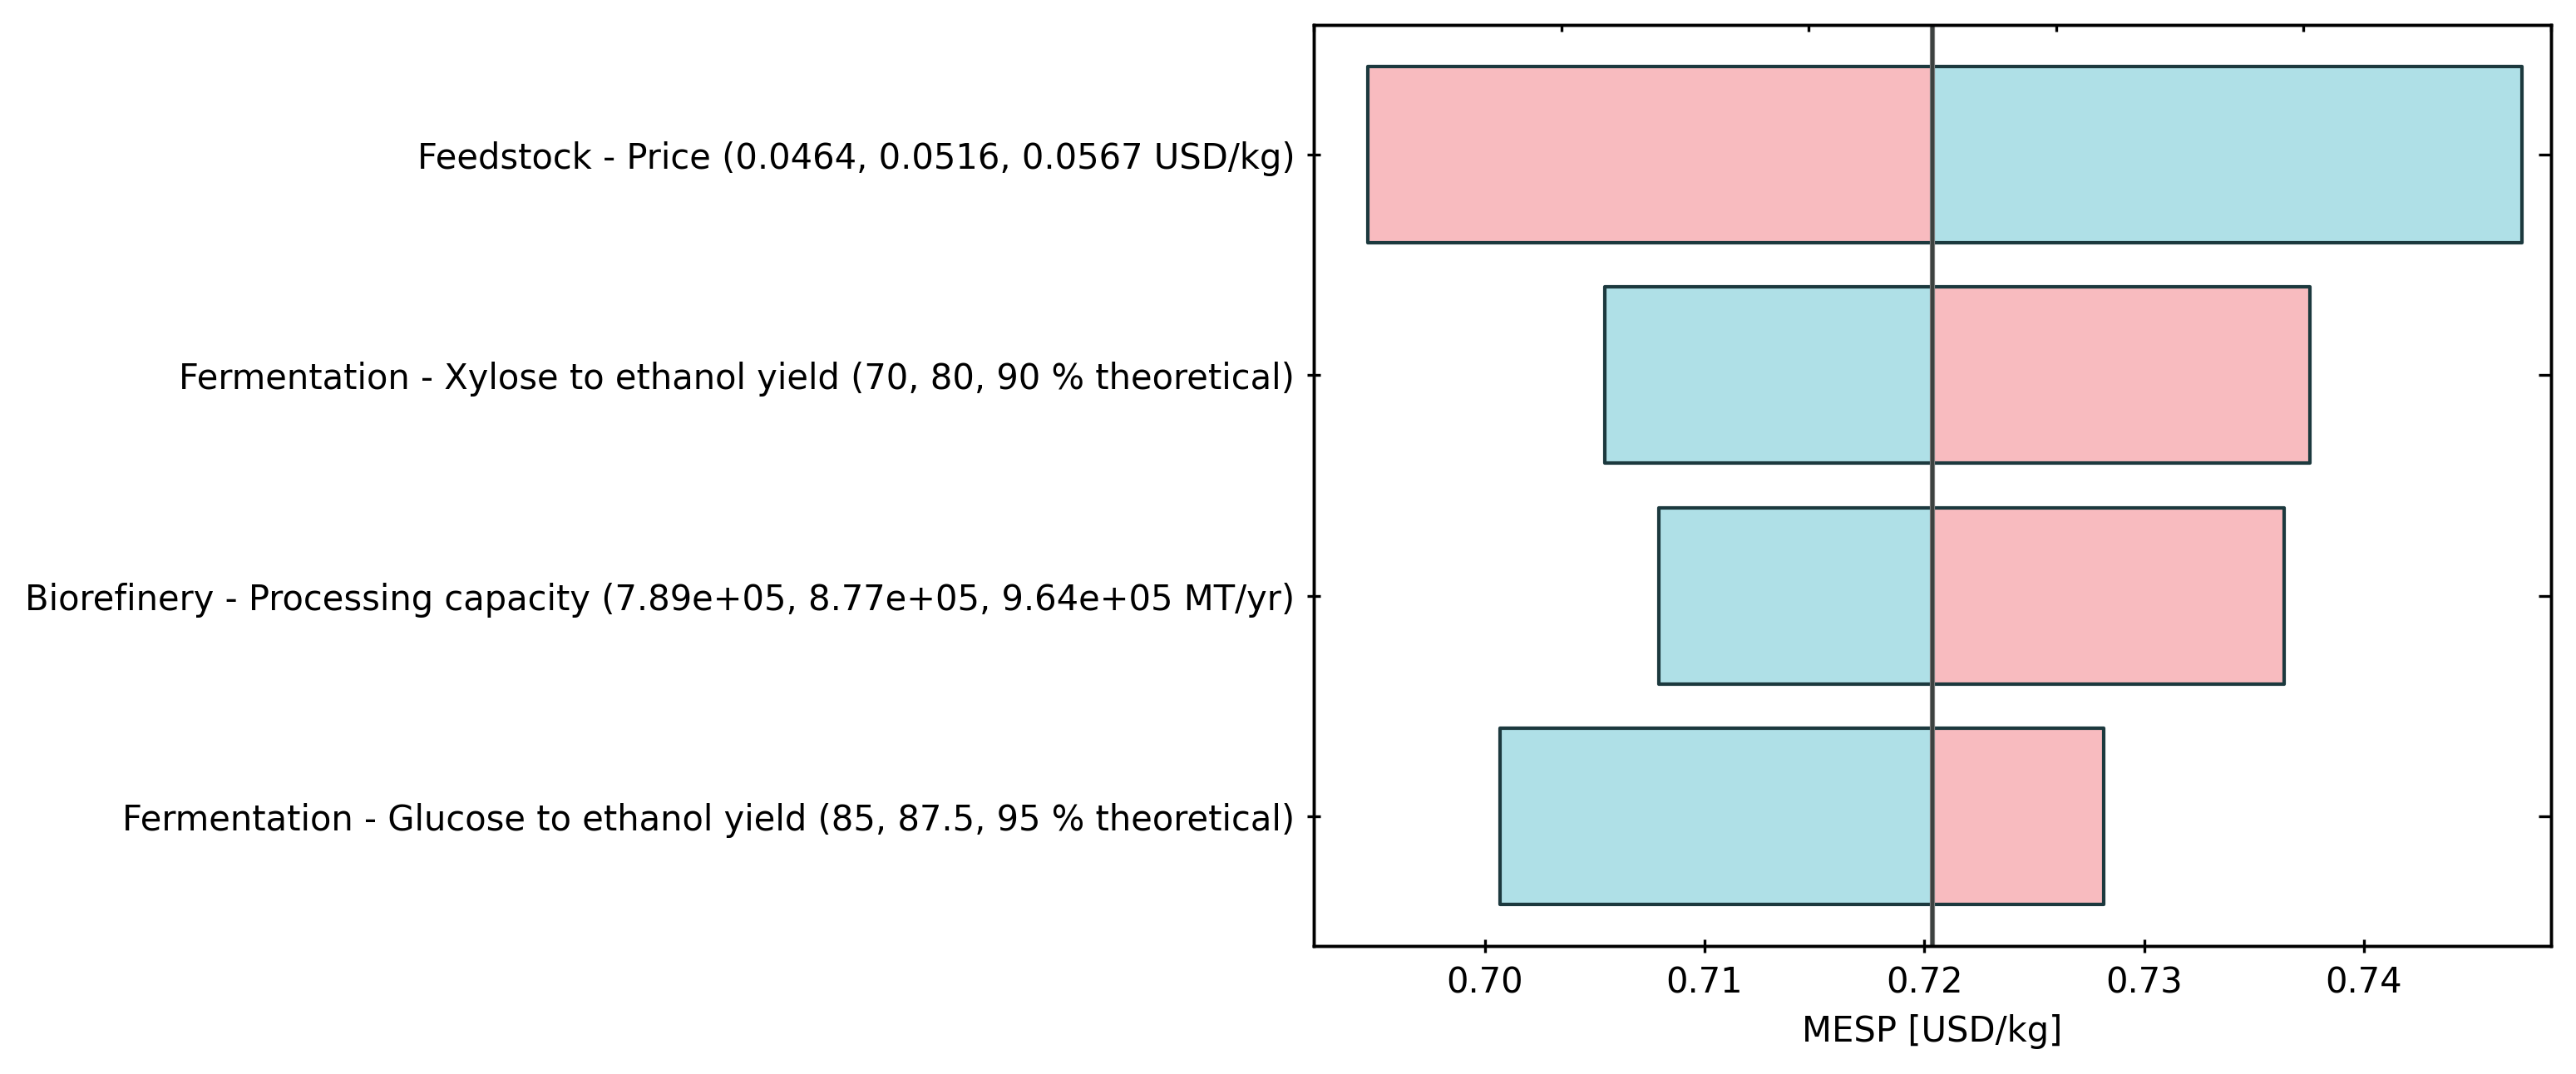

In [20]:
MESP, TCI = model.indicators
metric_index = MESP.index
index = [i.describe(distribution=False) # Instead of displaying distribution, it displays lower, baseline, and upper values
         for i in model.parameters] 
bst.plots.plot_single_point_sensitivity(baseline[metric_index],
                                        lower[metric_index], 
                                        upper[metric_index],
                                        name='MESP [USD/kg]',
                                        index=index)

Note that blue represents the upper limit while red the lower limit. Also note that local sensitivity (as estimated by the single point sensitivity analysis) is different from the global sensitivity (estimated by Spearman's rank order correlation coefficient of Monte Carlo results).

## Scenario analysis

Let's have a look at two different potential scenarios: a conservative and a prospective "improved" fermentation performance.

In [21]:
set_glucose_to_ethanol_yield.active = False
set_xylose_to_ethanol_yield.active = False
set_glucose_to_ethanol_yield(85)
set_xylose_to_ethanol_yield(80)
model.evaluate() # Reevaluate at the conservative scenario sub-space
conservative_scenario_subspace = model.table.copy()
set_glucose_to_ethanol_yield(95)
set_xylose_to_ethanol_yield(90)
model.evaluate() # Reevaluate at the prospective scenario sub-space
prospective_scenario_subspace = model.table.copy()

Text(0, 0.5, 'MESP [$\\mathrm{USD} \\cdot \\mathrm{kg}^{-1}$]')

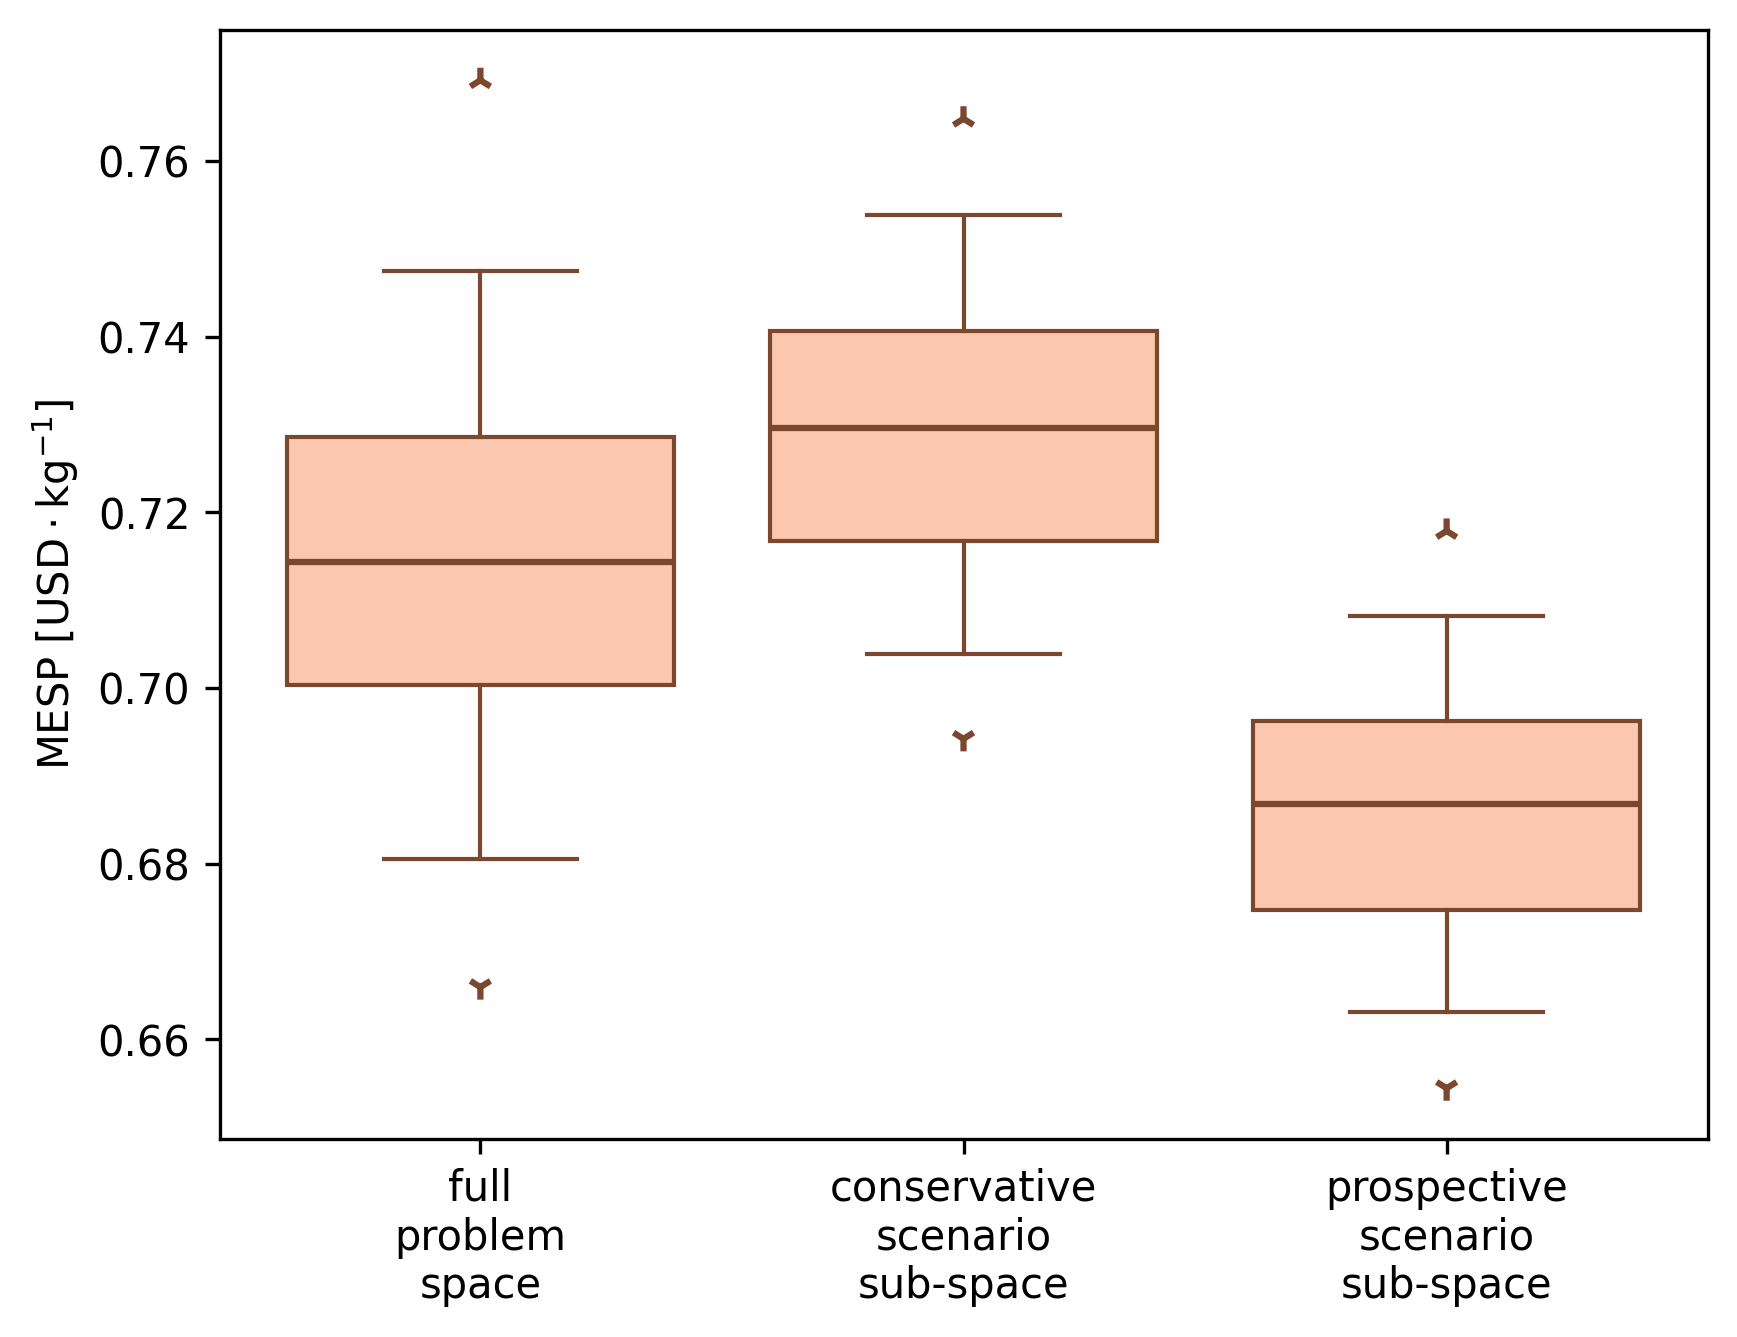

In [22]:
scenarios = [
    'full problem space',
    'conservative scenario sub-space',
    'prospective scenario sub-space',
]
data = [
    full_problem_space,
    conservative_scenario_subspace,
    prospective_scenario_subspace,
]
dct = bst.plots.plot_montecarlo(
    data=np.array([i[MESP.index] for i in data]), 
    xmarks=[i.replace(' ', '\n') for i in scenarios]
)
plt.ylabel(ylabel)

Note how the targeted improvements to fermentation can benefit economic outcomes. We can also directly compare these key scenario sub-spaces under harmonized assumptions on price and processing capacity.

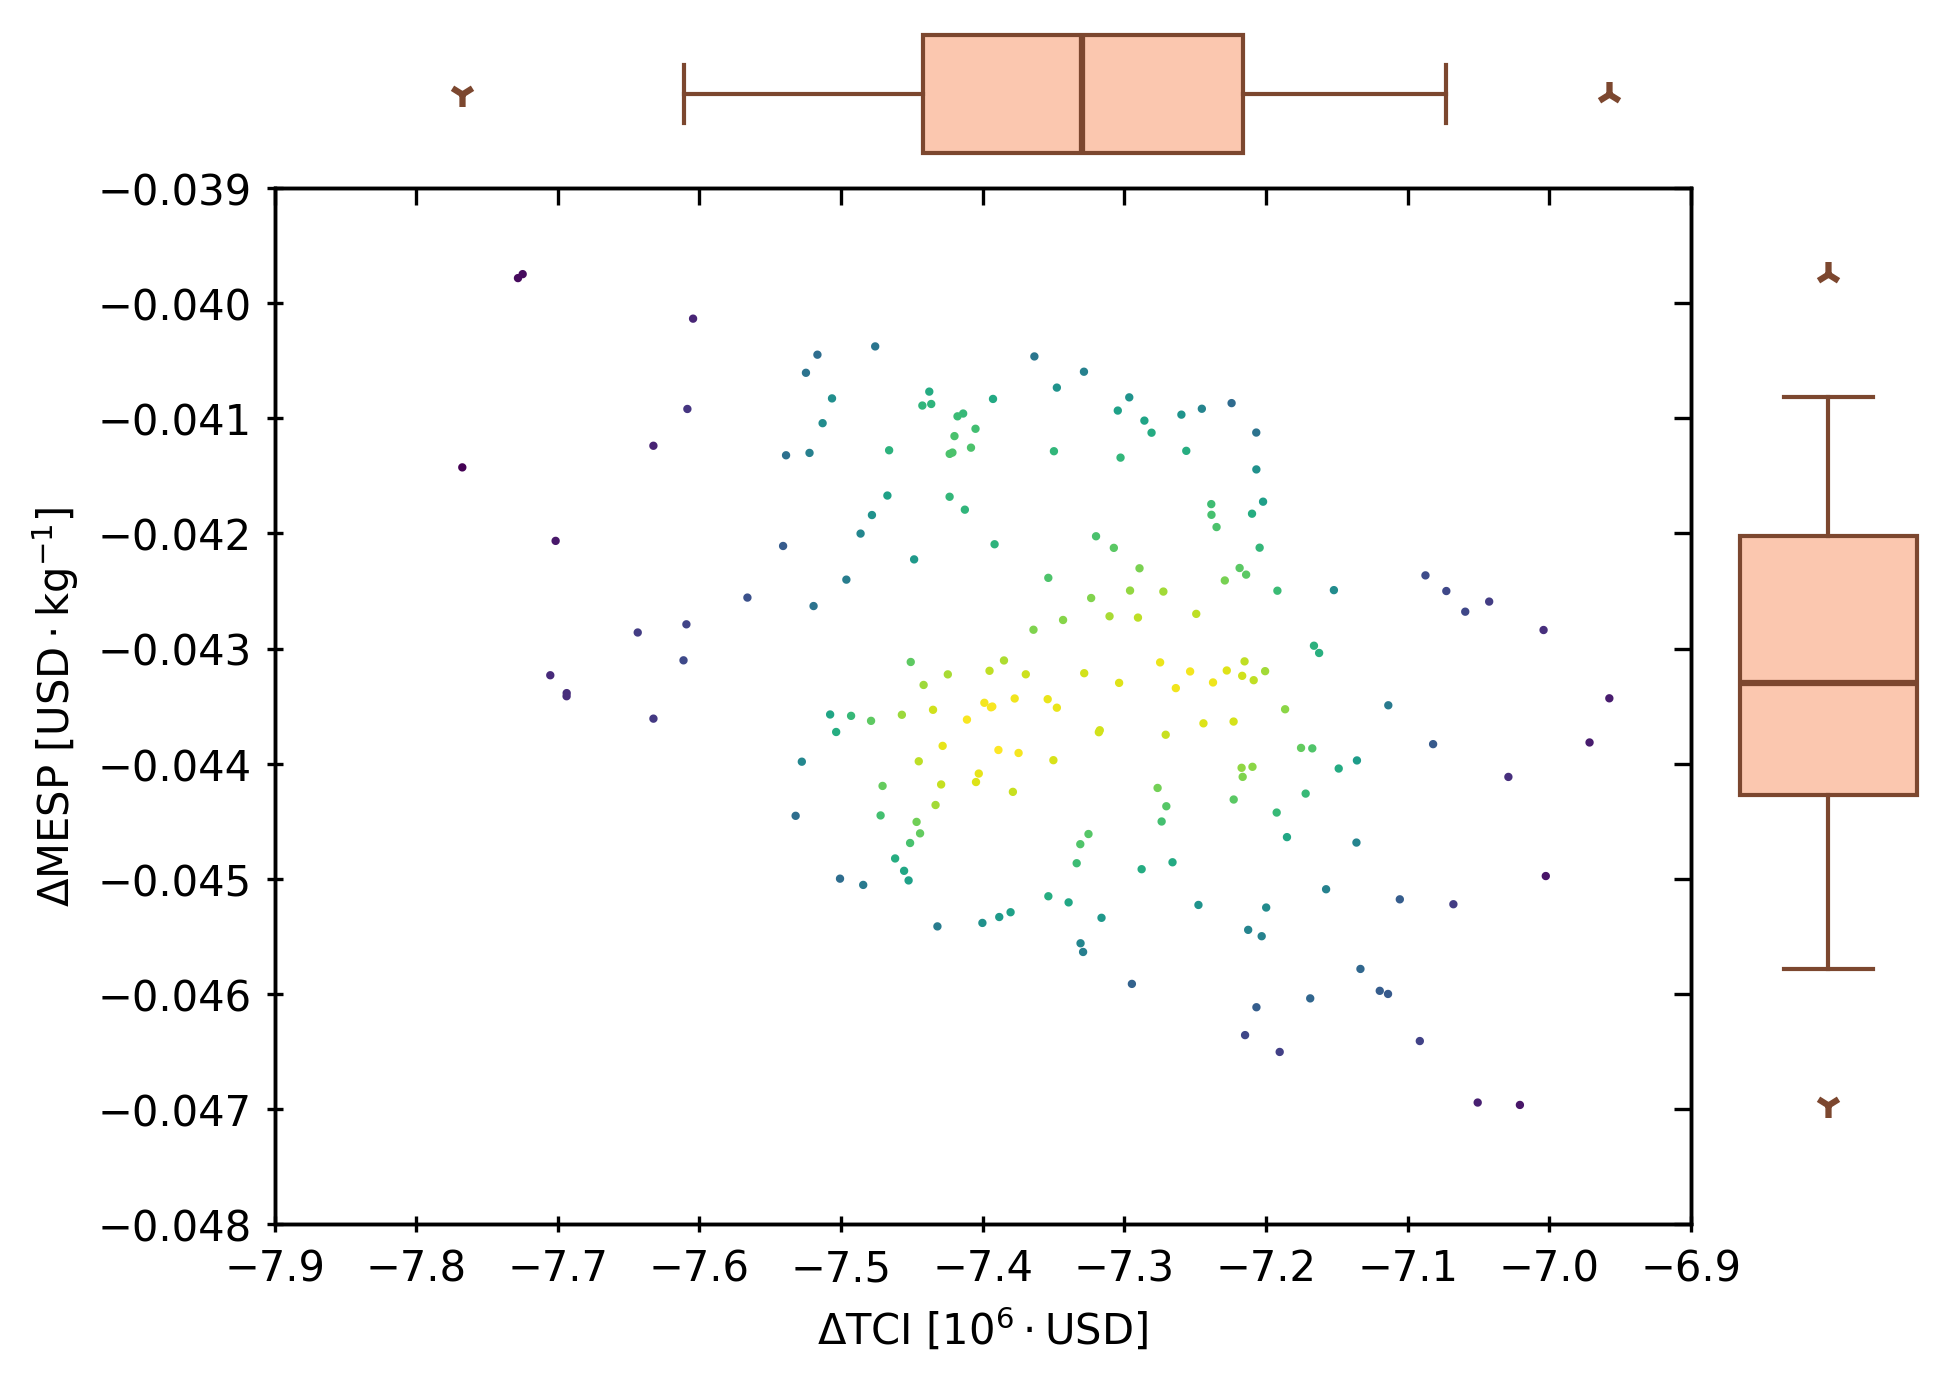

In [23]:
improvement = prospective_scenario_subspace - conservative_scenario_subspace
fig, ax, axes = bst.plots.plot_kde(
    y=improvement[MESP.index], 
    x=improvement[TCI.index],
    ylabel='$\Delta$' + ylabel,
    xlabel='$\Delta$' + xlabel,
    aspect_ratio=1.1,
)

Note how the prospective scenario subspace leads to lower MESP and TCI compared to the convervative scenario subspace.